In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../..")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import CirculatorSNAILGate
from src.cost_function import BasicCostInverse, BasicCost, BasicReducedCost
from src.optimizer import TemplateOptimizer
import h5py

Using a wrapper lambda to fix parameter values in the basis gate for all search time. (Alternative is to fix only at beginning by overriding the beginning parameter guess - say if want to start near some known value but on new attempt let other variable that were previously fixed have some wiggle room)

In [2]:
# from src.basisv2 import CircuitTemplateV2
# from src.utils.custom_gates import CirculatorSNAILGate
# bind_lambda = lambda g_ab, t: CirculatorSNAILGate(0, 0, 0, np.pi/2, 0, 0, t)
# basis = CircuitTemplateV2(n_qubits=3, base_gates = [bind_lambda], edge_params=[[(0,1,2)]])
# basis.build(2)
# basis.spanning_range = range(2,3)
# basis.circuit.draw(output='mpl')

In [3]:
# basis.add_bound("Q1", max=1, min=0)
# basis.add_bound("Q3", max=1, min=0)

This template is same as from continuous_basis now, we have 2 iswap gates that are free to adjust their times. However, we have a 3rd qubit ancilla. That probably is not very helpful - we should remove it and just rewrite the gate class to be more adaptive. I think this test is at least a good way to quantify how much harder the increased hilbert space is for training - keeping the 3rd qubit just as ancilla.

In [4]:
# from src.cost_function import BasicCostInverse, BasicCost
# objective1 = BasicCost()
# objective2 = BasicCostInverse()
# from src.optimizer import TemplateOptimizer
# optimizer = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True)

In [5]:
# from src.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]
# s = np.kron(s, np.eye(2))
# ret = optimizer.approximate_target_U(s)

In [6]:
# basis.build(ret.cycles)
# circuit =basis.assign_Xk(ret.Xk)
# print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret.Xk), s))
# print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
# print("Total Fidelity", 1-ret.loss_result)
# circuit.draw(output='mpl')

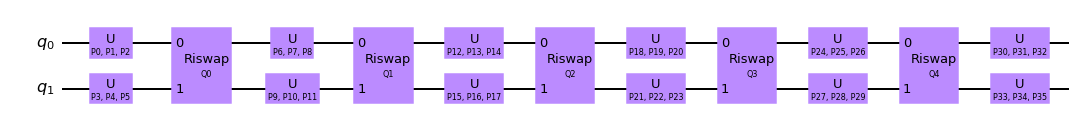

In [7]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import RiSwapGate
from src.utils.custom_gates import ConversionGainSmushGate, ConversionGainGate


# if using riswap
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
basis_str = "riswap"

# if using the 2Q gate
# pp2 =lambda *vargs: ConversionGainGate(0,0 , vargs[0], vargs[1], t_el=1.0)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], param_vec_expand=[2,1,1])
# basis_str = "CG2Q"

# need to build first before can assign bounds
basis.build(5)
basis.spanning_range = range(3,6)

#bound all Qs to be >0
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, 0.5, 0)

# print out for confirmation 
basis.circuit.draw(output='mpl')

In [8]:
# from src.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]

from src.sampler import HaarSample, GateSample
#sampler = HaarSample(seed=0,n_samples=1) #don't care
from qiskit.circuit.library import CXGate, CZGate, SwapGate
#sampler = GateSample(gate = CZGate())
#sampler = GateSample(gate = CZGate())
sampler = GateSample(gate = SwapGate())
s = [s for s in sampler][0]

In [ ]:
# # Here we want to save the best cost as a function of the success threshold
# success_thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
# fidelities = [None]*len(success_thresholds)
# for k, success_threshold in enumerate(success_thresholds):
#     objective1 = BasicCost()
#     # keep trying until success_threshold converges:
#     i=0
#     LB = 1.25
#     UB = 1.5
#     current_cost = (UB - LB)/2

#     # keep trying until success_threshold converges:
#     while i == 0 or np.abs(current_cost - previous_cost) > 0.01:
#         if not current_cost is None:
#             basis.set_constraint(param_max_cost=current_cost)
#             #pass
#         #rebuild optimizer to refresh the updated f_basis obj
#         #NOTE setting the success threshold low since SWAP is very hard to find exactly
#         optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, success_threshold = 1- success_threshold, training_restarts=25)

#         _ret3 = optimizer3.approximate_target_U(s)
#         current_cost = basis.circuit_cost(_ret3.Xk)
#         print(f"Iteration:{i}, Decomposition Result:{_ret3.loss_result}, Cost:{current_cost},")

#         #search using 2 steps forward, 1 step back approach BAD
#         # I want to do a binary search between 0 and 1.5 
#         # if success, then set next cost to be current - LB / 2
#         # if fail, then set next cost to be current + (UB - current) / 2
        
#         if _ret3.success_label:
#             ret3 = _ret3
#             fidelities[k] = ret3

#             #success means can tighten the constraint
#             previous_cost = current_cost
#             current_cost = (current_cost - LB)/2
#             print("Success, new cost:", current_cost)

#         else:
#             #fail means loosen the constraint
#             previous_cost = current_cost
#             current_cost = current_cost + (UB - current_cost)/2
#             print("Fail, new cost:", current_cost)
    
#         i+=1

#     # save fidelities to h5 file
#     with h5py.File(f'swap_fidelities_{basis_str}.h5', 'a') as hf:
#         #if dataset exists, delete it
#         if f"success_{success_threshold}" in hf:
#             del hf[f"success_{success_threshold}"]
#         hf.create_dataset(f"success_{success_threshold}", data=fidelities[k])

In [14]:
# load from file
with h5py.File(f'swap_fidelities_{basis_str}.h5', 'r') as hf:
    for k, success_threshold in enumerate(success_thresholds):
        loss = hf[f"success_{success_threshold}"]['loss'][...]
        cost = hf[f"success_{success_threshold}"]['cost'][...]
        print(f"Success Threshold: {success_threshold}, Loss: {loss}, Cost: {cost}")

Success Threshold: 0.99, Loss: [0.00920635], Cost: [1.34489258]
Success Threshold: 0.999, Loss: [0.00075984], Cost: [1.45142365]
Success Threshold: 0.9999, Loss: [6.35836601e-05], Cost: [1.48346138]
Success Threshold: 0.99999, Loss: [6.35836601e-05], Cost: [1.49462891]
Success Threshold: 0.999999, Loss: [6.35836601e-05], Cost: [1.49462891]


Circuit duration cost 1.35
Decomposition Fidelity 4.367250927561628e-07
Total Fidelity 0.9999995632749072


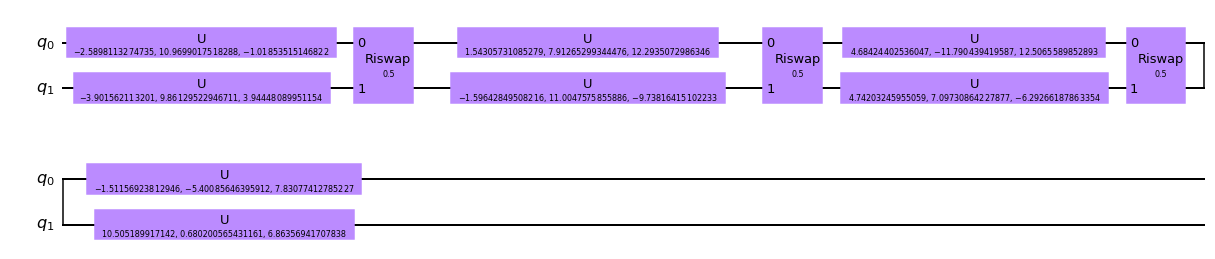

In [ ]:
basis.build(ret3.cycles)
circuit =basis.assign_Xk(ret3.Xk)
print("Circuit duration cost", basis.circuit_cost(_ret3.Xk))
print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret3.Xk), s))
# print("Circuit Fidelity", basis.circuit_fidelity(ret3.Xk))
print("Total Fidelity", 1-ret3.loss_result)
circuit.draw(output='mpl')